# Comparación de Algoritmos de Imputación de Valores Faltantes
Este notebook contiene una comparación de diferentes algoritmos de imputación aplicados a dos datasets: el conjunto de datos de **California Housing** y el conjunto de **Diabetes**. La imputación se realiza utilizando métodos simples como la media, mediana y moda, y métodos más avanzados como KNN, MICE y Random Forest. Se evaluarán el error absoluto medio (MAE), el error cuadrático medio (RMSE) y los tiempos de ejecución.

En esta sección, se definen las variables y se importan las librerías necesarias para el análisis de imputación de valores faltantes. A continuación, se detallan los pasos realizados:

1. **Importación de Librerías**: Se importan las librerías `numpy`, `pandas`, `sklearn`, `fancyimpute`, `missingno`, `seaborn` y `matplotlib` para la manipulación de datos, imputación de valores faltantes, visualización y evaluación de modelos.
2. **Carga de Datasets**: Se cargan los datasets de **California Housing** y **Diabetes** utilizando las funciones `fetch_california_housing` y `load_diabetes` de `sklearn.datasets`.
3. **Normalización de Datos**: Se normalizan los datos utilizando `MinMaxScaler` para escalar los valores entre 0 y 1.
4. **Introducción de Valores Faltantes**: Se introducen valores faltantes de manera aleatoria en el 20% de las filas de cada columna de los DataFrames normalizados.
5. **Visualización de Valores Faltantes**: Se utiliza la librería `missingno` para visualizar la matriz de valores faltantes en los datasets.
6. **Guardado de Valores Originales**: Se guardan copias de los DataFrames con los valores originales (sin valores faltantes) para su posterior uso en el cálculo de errores de imputación.

In [6]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from fancyimpute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

En esta sección, cargamos el dataset **California Housing** y realizamos varias operaciones para preparar los datos para el análisis de imputación de valores faltantes. A continuación, se detallan los pasos realizados:

1. **Carga del Dataset**: Utilizamos la función `fetch_california_housing` de `sklearn.datasets` para cargar el dataset de California Housing en un DataFrame de pandas.
2. **Reducción del Tamaño del Dataset**: Seleccionamos una muestra aleatoria de 1000 registros del dataset original para reducir el tamaño y facilitar el análisis.
3. **Normalización de los Datos**: Aplicamos la normalización a los datos utilizando `MinMaxScaler` de `sklearn.preprocessing` para escalar los valores entre 0 y 1.
4. **Introducción de Valores Faltantes**: Introducimos valores faltantes de manera aleatoria en el 20% de las filas de cada columna del DataFrame normalizado.
5. **Visualización de Valores Faltantes**: Utilizamos la librería `missingno` para visualizar la matriz de valores faltantes en el dataset.
6. **Guardado de Valores Originales**: Guardamos una copia del DataFrame con los valores originales (sin valores faltantes) para su posterior uso en el cálculo de errores de imputación.

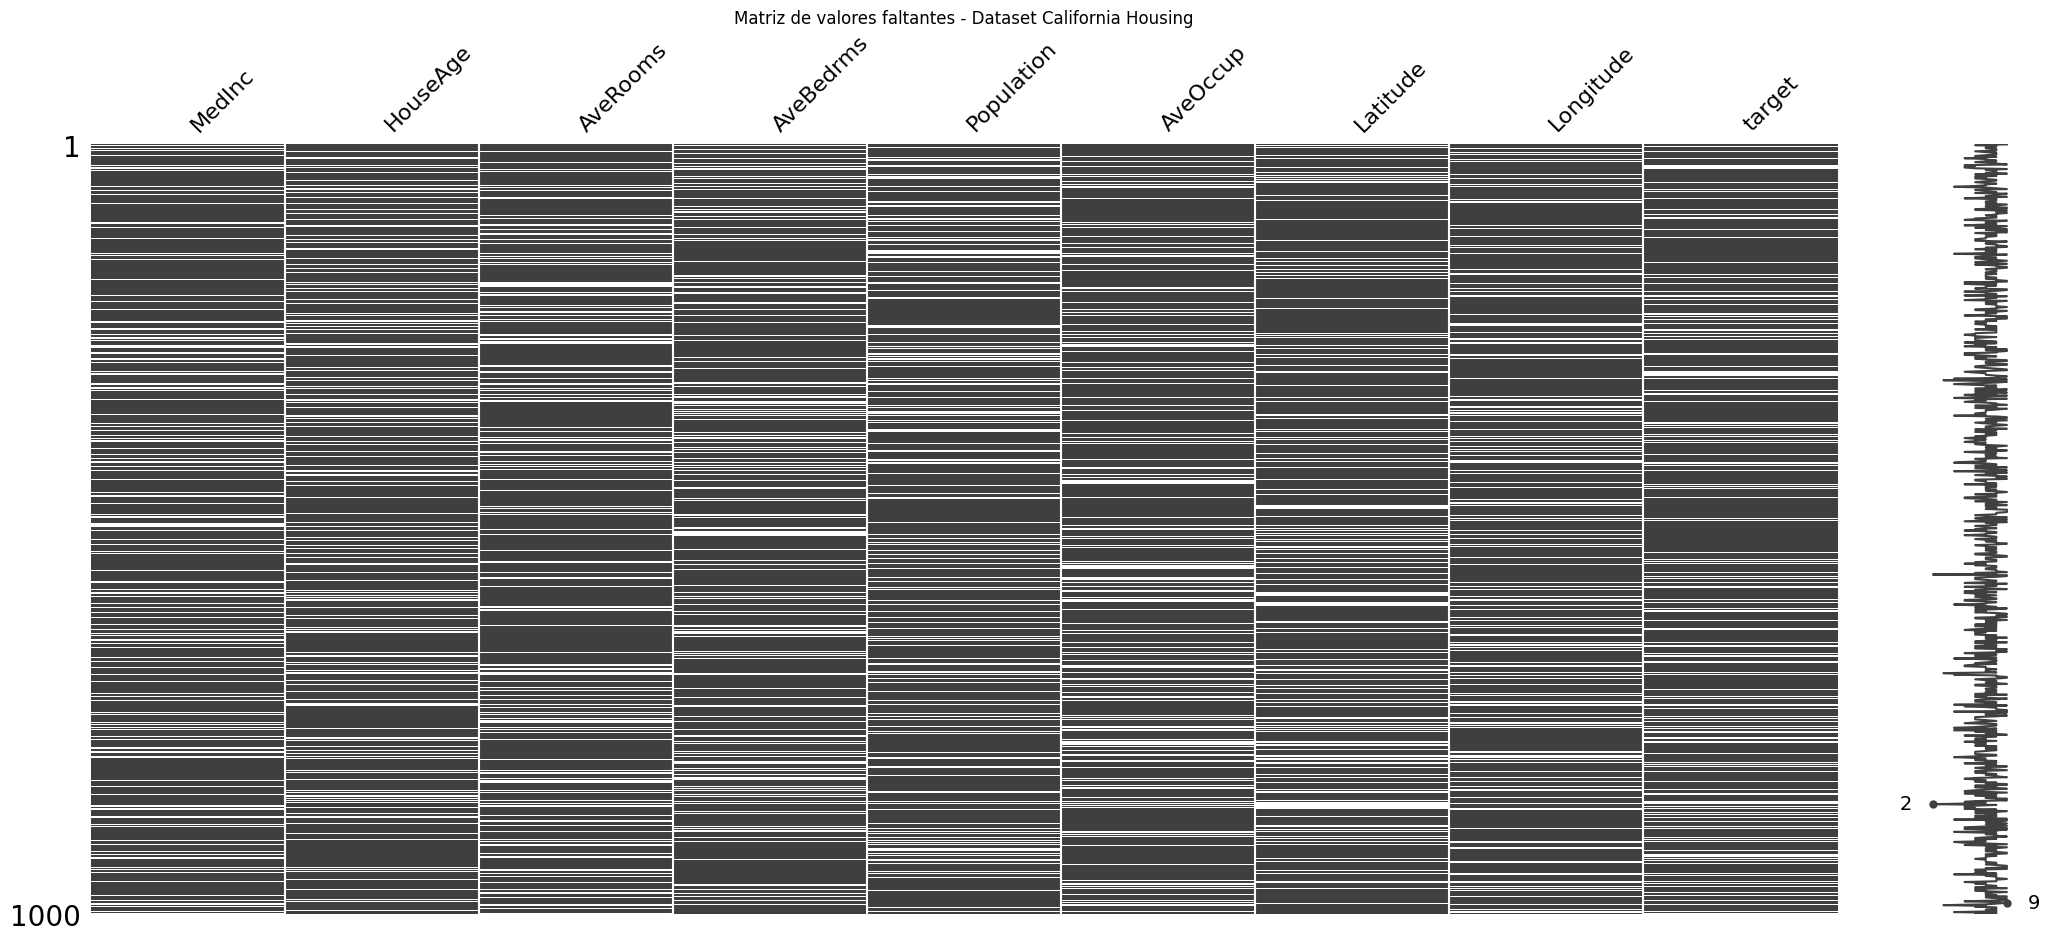

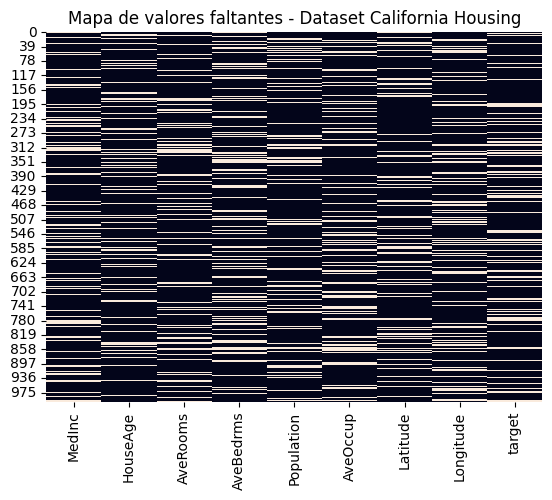

In [7]:
data = fetch_california_housing()
df_california = pd.DataFrame(data.data, columns=data.feature_names)
df_california['target'] = data.target

# Reducir el tamaño del dataset (1000 muestras)
df_california = df_california.sample(n=1000, random_state=0)

# Normalizar los datos
scaler = MinMaxScaler()
df_california_scaled = pd.DataFrame(scaler.fit_transform(df_california), columns=df_california.columns)

# Introducir valores faltantes (20% en cada columna)
np.random.seed(0)
for col in df_california_scaled.columns:
    df_california_scaled.loc[df_california_scaled.sample(frac=0.2).index, col] = np.nan

# Visualización de los valores faltantes
msno.matrix(df_california_scaled)
plt.title("Matriz de valores faltantes - Dataset California Housing")
plt.show()

# Mapa de calor de los valores faltantes
sns.heatmap(df_california_scaled.isnull(), cbar=False)
plt.title("Mapa de valores faltantes - Dataset California Housing")
plt.show()

# Guardar valores originales para calcular errores
california_valores_originales = df_california_scaled.copy()

En esta sección, cargamos el dataset **Diabetes** y realizamos varias operaciones para preparar los datos para el análisis de imputación de valores faltantes. A continuación, se detallan los pasos realizados:

1. **Carga del Dataset**: Utilizamos la función `load_diabetes` de `sklearn.datasets` para cargar el dataset de Diabetes en un DataFrame de pandas.
2. **Normalización de los Datos**: Aplicamos la normalización a los datos utilizando `MinMaxScaler` de `sklearn.preprocessing` para escalar los valores entre 0 y 1.
3. **Introducción de Valores Faltantes**: Introducimos valores faltantes de manera aleatoria en el 20% de las filas de cada columna del DataFrame normalizado.
4. **Visualización de Valores Faltantes**: Utilizamos la librería `missingno` para visualizar la matriz de valores faltantes en el dataset.
5. **Guardado de Valores Originales**: Guardamos una copia del DataFrame con los valores originales (sin valores faltantes) para su posterior uso en el cálculo de errores de imputación.

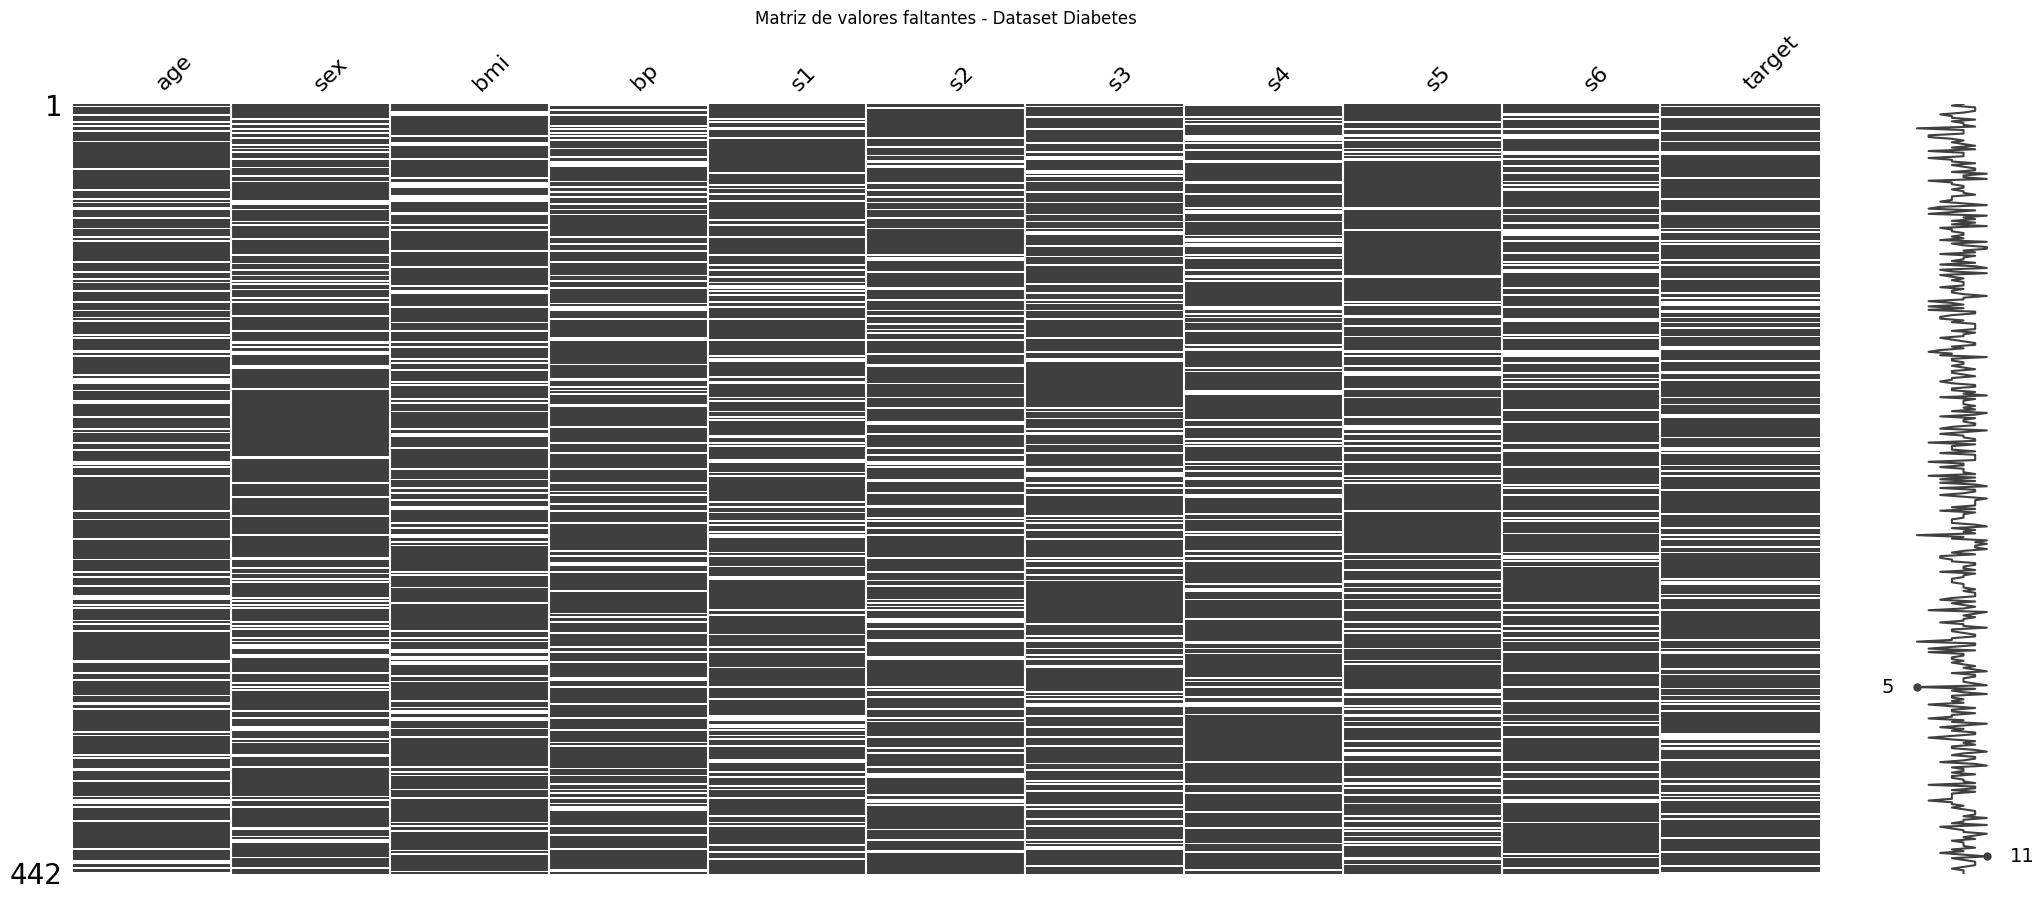

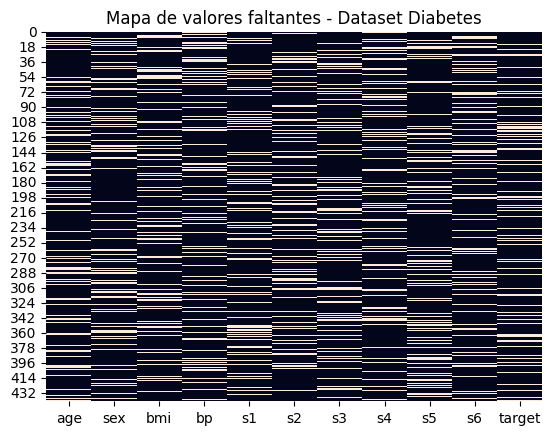

In [8]:
data = load_diabetes()
df_diabetes = pd.DataFrame(data.data, columns=data.feature_names)
df_diabetes['target'] = data.target

# Normalizar los datos
scaler = MinMaxScaler()
df_diabetes_scaled = pd.DataFrame(scaler.fit_transform(df_diabetes), columns=df_diabetes.columns)

# Introducir valores faltantes (20% en cada columna)
np.random.seed(0)
for col in df_diabetes_scaled.columns:
    df_diabetes_scaled.loc[df_diabetes_scaled.sample(frac=0.2).index, col] = np.nan

# Visualización de los valores faltantes
msno.matrix(df_diabetes_scaled)
plt.title("Matriz de valores faltantes - Dataset Diabetes")
plt.show()

# Mapa de calor de los valores faltantes
sns.heatmap(df_diabetes_scaled.isnull(), cbar=False)
plt.title("Mapa de valores faltantes - Dataset Diabetes")
plt.show()

# Guardar valores originales para calcular errores
diabetes_valores_originales = df_diabetes_scaled.copy()

Hacemos una función para imputar varios métodos a la vezLa función `imputar_metodos` aplica varios métodos de imputación a un DataFrame con valores faltantes y evalúa su rendimiento. Los métodos de imputación utilizados son:

- Media
- Mediana
- Moda
- KNN (K-Nearest Neighbors)
- MICE (Multiple Imputation by Chained Equations)
- Random Forest

Para cada método, la función calcula el error absoluto medio (MAE), el error cuadrático medio (RMSE) y el tiempo de ejecución. Los resultados se devuelven en un DataFrame.

### Parámetros:
- `df_scaled`: DataFrame con los datos normalizados y valores faltantes.
- `valores_originales`: DataFrame con los valores originales (sin valores faltantes) para calcular los errores.
- `nombre_dataset`: Nombre del dataset para referencia.

### Salida:
- DataFrame con los resultados de la imputación, incluyendo el método utilizado, MAE, RMSE y tiempo de ejecución.

In [9]:
# Función para imputar con varios métodos
def imputar_metodos(df_scaled, valores_originales, nombre_dataset):
    imputers = {
        "Media": SimpleImputer(strategy='mean'),
        "Mediana": SimpleImputer(strategy='median'),
        "Moda": SimpleImputer(strategy='most_frequent'),
        "KNN": KNNImputer(n_neighbors=5),
        "MICE": IterativeImputer(max_iter=10, random_state=0),
        "Random Forest": IterativeImputer(estimator=RandomForestRegressor(),random_state=0)
    }
    
    results = {"Método": [], "MAE": [], "RMSE": [], "Tiempo": []}
    
    for nombre, imputer in imputers.items():
        start_time = time.time()
        df_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_scaled.columns)
        mae = mean_absolute_error(valores_originales.fillna(0), df_imputed)
        rmse = np.sqrt(mean_squared_error(valores_originales.fillna(0), df_imputed))
        tiempo = time.time() - start_time
        
        results["Método"].append(nombre)
        results["MAE"].append(mae)
        results["RMSE"].append(rmse)
        results["Tiempo"].append(tiempo)
    
    return pd.DataFrame(results)

En esta sección, se realiza la imputación de valores faltantes y la comparación de resultados para los datasets **California Housing** y **Diabetes**. A continuación, se detallan los pasos realizados:

1. **Imputación de Valores Faltantes**: Se aplica la función `imputar_metodos` a los DataFrames `df_california_scaled` y `df_diabetes_scaled` para imputar los valores faltantes utilizando varios métodos (Media, Mediana, Moda, KNN, MICE y Random Forest).
2. **Cálculo de Errores y Tiempos de Ejecución**: Para cada método de imputación, se calculan el error absoluto medio (MAE), el error cuadrático medio (RMSE) y el tiempo de ejecución.
3. **Comparación de Resultados**: Se almacenan y muestran los resultados de la imputación para ambos datasets en los DataFrames `resultados_california` y `resultados_diabetes`.

Los resultados obtenidos permiten evaluar la efectividad de cada método de imputación en términos de precisión y eficiencia.

In [10]:
# Imputación y comparación de resultados para ambos datasets
resultados_california = imputar_metodos(df_california_scaled, california_valores_originales, "California")
resultados_diabetes = imputar_metodos(df_diabetes_scaled, diabetes_valores_originales, "Diabetes")

# Mostrar resultados
print("Resultados - Dataset California Housing")
print(resultados_california)
print("")
print("Resultados - Dataset Diabetes")
print(resultados_diabetes)

c:\Users\tavin\OneDrive - Universidad de Oviedo\4to AÑO\NEGOCIO\TEORIA\comparacion_imputacion\venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\tavin\OneDrive - Universidad de Oviedo\4to AÑO\NEGOCIO\TEORIA\comparacion_imputacion\venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\tavin\OneDrive - Universidad de Oviedo\4to AÑO\NEGOCIO\TEORIA\comparacion_imputacion\venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Resultados - Dataset California Housing
          Método       MAE      RMSE     Tiempo
0          Media  0.051793  0.137778   0.007006
1        Mediana  0.047565  0.135102   0.007006
2           Moda  0.069851  0.234039   0.010010
3            KNN  0.051884  0.145878   0.061861
4           MICE  0.053138  0.153487   0.114296
5  Random Forest  0.052981  0.153501  51.243112

Resultados - Dataset Diabetes
          Método       MAE      RMSE     Tiempo
0          Media  0.084263  0.191297   0.007007
1        Mediana  0.072835  0.174322   0.007006
2           Moda  0.061191  0.154228   0.010009
3            KNN  0.083088  0.198877   0.020019
4           MICE  0.083381  0.201067   0.147134
5  Random Forest  0.084512  0.204478  27.571990


c:\Users\tavin\OneDrive - Universidad de Oviedo\4to AÑO\NEGOCIO\TEORIA\comparacion_imputacion\venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


En esta sección, se grafican los resultados de la imputación de valores faltantes para los datasets **California Housing** y **Diabetes**. A continuación, se detallan los pasos realizados:

1. **Definición de la Función de Gráficos**: Se define la función `graficar_resultados` que crea gráficos de barras para comparar los errores absolutos medios (MAE), los errores cuadráticos medios (RMSE) y los tiempos de ejecución de los diferentes métodos de imputación.
2. **Generación de Gráficos**: Se generan gráficos de comparación para los datasets `resultados_california` y `resultados_diabetes` utilizando la función `graficar_resultados`.
3. **Visualización de Resultados**: Se muestran los gráficos de MAE, RMSE y tiempos de ejecución para evaluar visualmente la efectividad y eficiencia de cada método de imputación.

Estos gráficos permiten una comparación visual clara de los diferentes métodos de imputación aplicados a ambos datasets.

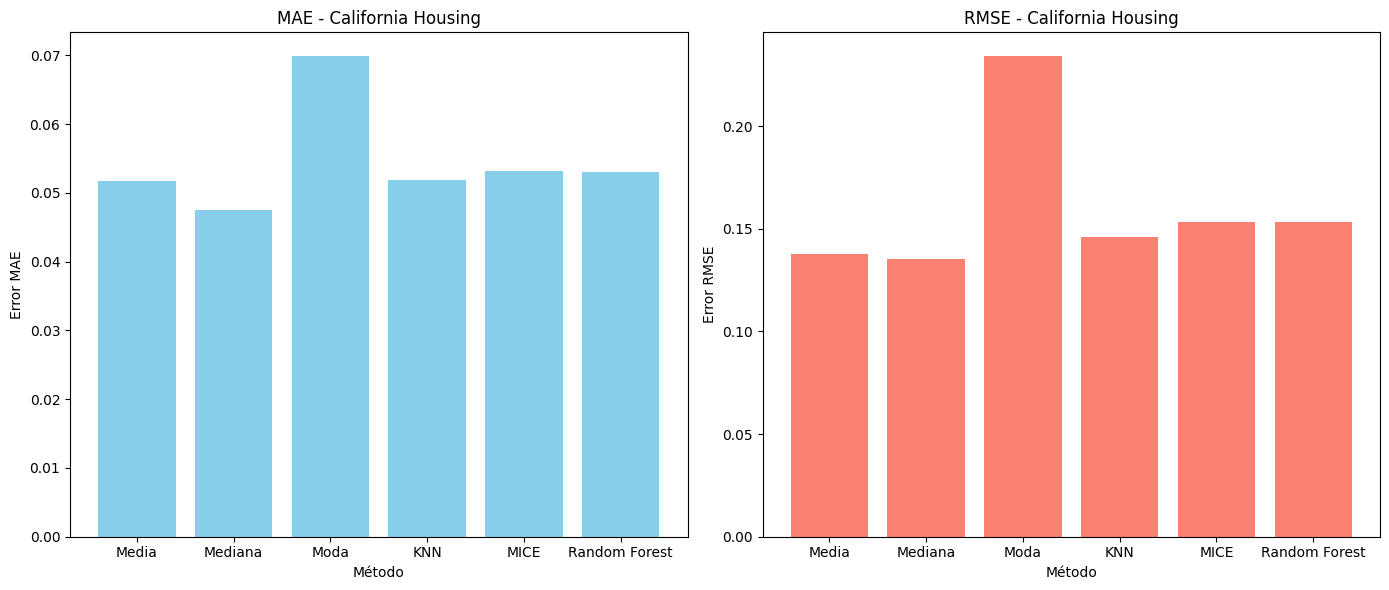

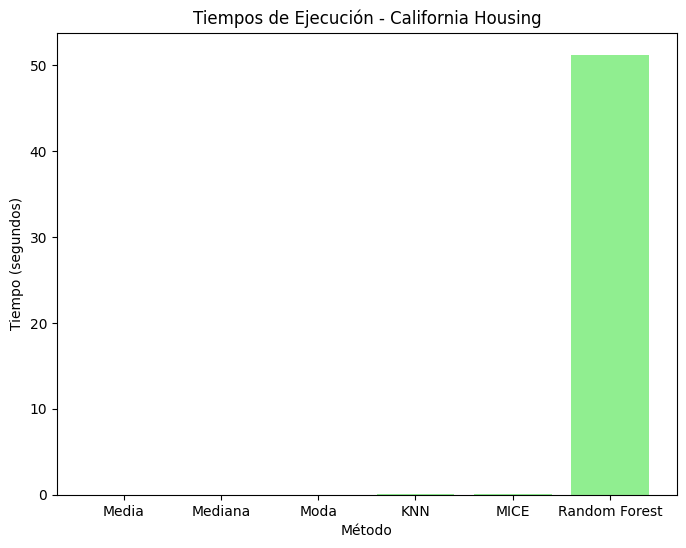

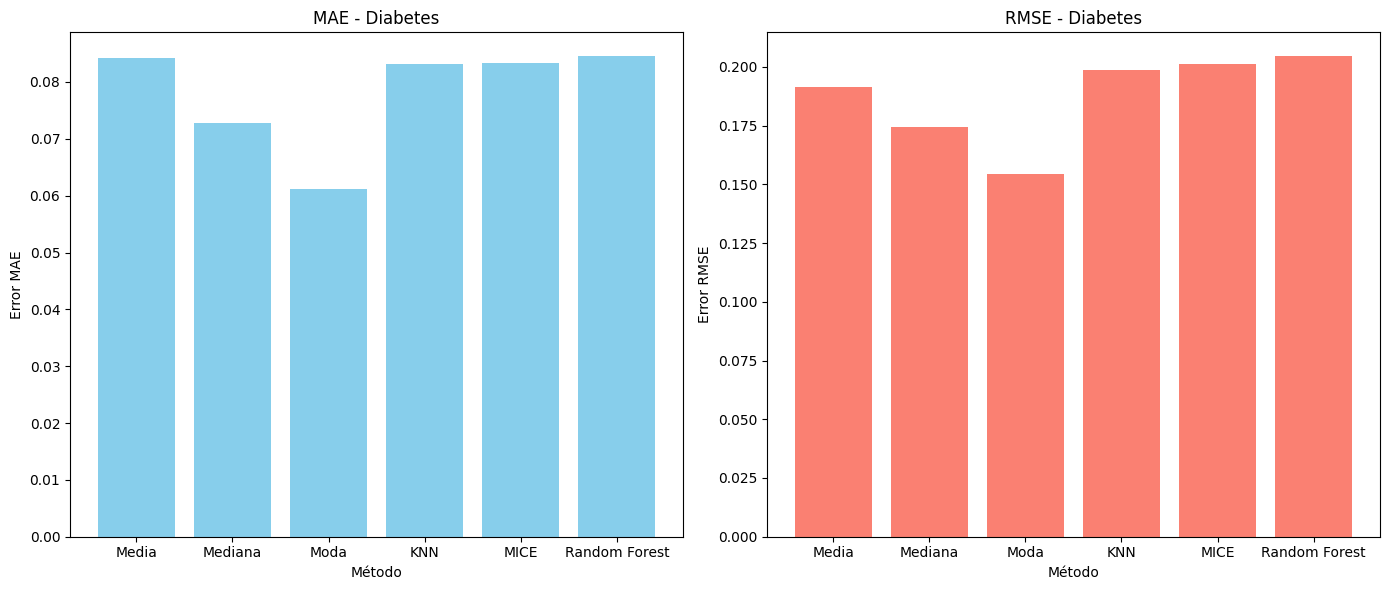

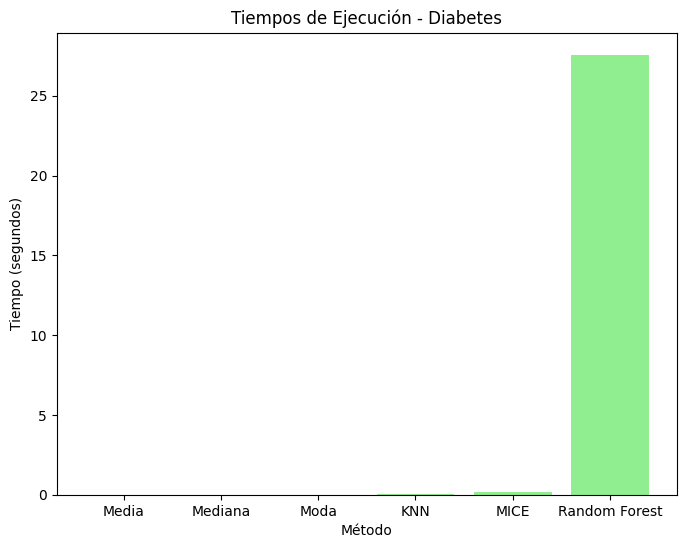

In [11]:
# Gráficos de comparación de errores y tiempos de ejecución
def graficar_resultados(resultados, nombre_dataset):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfico de MAE
    ax[0].bar(resultados["Método"], resultados["MAE"], color='skyblue')
    ax[0].set_title(f"MAE - {nombre_dataset}")
    ax[0].set_xlabel("Método")
    ax[0].set_ylabel("Error MAE")
    
    # Gráfico de RMSE
    ax[1].bar(resultados["Método"], resultados["RMSE"], color='salmon')
    ax[1].set_title(f"RMSE - {nombre_dataset}")
    ax[1].set_xlabel("Método")
    ax[1].set_ylabel("Error RMSE")
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico de tiempos de ejecución
    plt.figure(figsize=(8, 6))
    plt.bar(resultados["Método"], resultados["Tiempo"], color='lightgreen')
    plt.title(f"Tiempos de Ejecución - {nombre_dataset}")
    plt.xlabel("Método")
    plt.ylabel("Tiempo (segundos)")
    plt.show()

# Graficar resultados para ambos datasets
graficar_resultados(resultados_california, "California Housing")
graficar_resultados(resultados_diabetes, "Diabetes")

### Conclusión de los Gráficos de Imputación de Valores Faltantes

Los gráficos generados permiten comparar visualmente la efectividad y eficiencia de diferentes métodos de imputación aplicados a los datasets **California Housing** y **Diabetes**. A continuación, se presentan las conclusiones principales:

1. **Error Absoluto Medio (MAE)**:
    - Para el dataset **California Housing**, los métodos de imputación con menor MAE fueron la **Mediana** y la **Media**, seguidos de cerca por **KNN** y **MICE**. La **Moda** presentó el mayor MAE.
    - En el dataset **Diabetes**, la **Moda** tuvo el menor MAE, seguida por la **Mediana**. Los métodos **KNN**, **MICE** y **Random Forest** presentaron MAEs similares y más altos.

2. **Error Cuadrático Medio (RMSE)**:
    - En el dataset **California Housing**, la **Mediana** y la **Media** también mostraron los menores RMSE, mientras que la **Moda** tuvo el mayor RMSE.
    - Para el dataset **Diabetes**, la **Moda** nuevamente tuvo el menor RMSE, seguida por la **Mediana**. Los métodos **KNN**, **MICE** y **Random Forest** presentaron RMSEs más altos.

3. **Tiempos de Ejecución**:
    - Los métodos **Media**, **Mediana** y **Moda** fueron los más rápidos en ambos datasets.
    - **KNN** y **MICE** tuvieron tiempos de ejecución moderados.
    - **Random Forest** fue el método más lento, especialmente en el dataset **California Housing**, donde el tiempo de ejecución fue significativamente mayor.

### Resumen

En general, los métodos simples como la **Media** y la **Mediana** proporcionaron buenos resultados en términos de MAE y RMSE con tiempos de ejecución muy bajos. La **Moda** mostró un rendimiento variable, siendo efectiva en el dataset **Diabetes** pero menos en el **California Housing**. Los métodos más avanzados como **KNN**, **MICE** y **Random Forest** no siempre mejoraron los errores de imputación y tuvieron tiempos de ejecución más largos, especialmente **Random Forest**. Por lo tanto, la elección del método de imputación debe considerar tanto la precisión como la eficiencia, dependiendo del contexto y los recursos disponibles.